In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from editdistance import eval as edit_distance

from simplipy import SimpliPyEngine

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.metrics import bootstrapped_metric_ci, zss_tree_edit_distance
from flash_ansr.eval.metrics.token_prediction import f1_score, precision, recall

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation', 'support_sweep')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
engine = SimpliPyEngine.load('dev_7-3', install=True)

In [4]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'pysr': {'scaling_parameter': 'support'},
    'nesymres': {'scaling_parameter': 'support'},
    'e2e': {'scaling_parameter': 'support'},
    'v23.0-3M': {'scaling_parameter': 'support'},
    'v23.0-20M': {'scaling_parameter': 'support'},
    'v23.0-120M': {'scaling_parameter': 'support'},
    'v23.0-1B': {'scaling_parameter': 'support'},
    # 'skeleton_pool': {'scaling_parameter': 'support'},
    # 'brute_force': {'scaling_parameter': 'support'},
}

In [5]:
TEST_SETS = ['v23_val', 'fastsrb'][1:]

In [6]:
models_not_found = []
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    results[model]['evaluations_list'] = {}
    found_dataset = False
    for dataset in TEST_SETS:
        try:
            evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, model, dataset))
            found_dataset = True
        except FileNotFoundError:
            print(f"{os.path.join(PATH_TO_EVALUATION_DATA, model, dataset)} not found, skipping.")
            continue

        evaluations_list = [d for d in evaluations_list if d.startswith(f'{scaling_parameter}_')]
        scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

        scaling_values_argsort = np.argsort(scaling_values)
        scaling_values = [scaling_values[i] for i in scaling_values_argsort]
        evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

        results[model]['scaling_values'] = scaling_values
        results[model]['evaluations_list'][dataset] = evaluations_list
        results[model]['results'] = {}

        print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
        for d in evaluations_list:
            print(f" - {d}")

    if not found_dataset:
        print(f"No datasets found for model {model}, removing from results.")
        models_not_found.append(model)

for model_not_found in models_not_found:
    del results[model_not_found]

Found 12 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
 - support_00001.pkl
 - support_00002.pkl
 - support_00004.pkl
 - support_00008.pkl
 - support_00016.pkl
 - support_00032.pkl
 - support_00064.pkl
 - support_00128.pkl
 - support_00256.pkl
 - support_00512.pkl
 - support_01024.pkl
 - support_02048.pkl
Found 12 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
 - support_00001.pkl
 - support_00002.pkl
 - support_00004.pkl
 - support_00008.pkl
 - support_00016.pkl
 - support_00032.pkl
 - support_00064.pkl
 - support_00128.pkl
 - support_00256.pkl
 - support_00512.pkl
 - support_01024.pkl
 - support_02048.pkl
Found 12 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
 - support_00001.pkl
 - support_00002.pkl
 - support_00004.pkl
 - support_00008.pkl
 - support_00016.pkl
 - support_00032.pkl
 - support_00064.pkl
 - support_00128.pkl
 - support_00256.pkl
 - support_00512.pkl
 - s

In [7]:
results

{'pysr': {'scaling_parameter': 'support',
  'evaluations_list': {'fastsrb': ['support_00001.pkl',
    'support_00002.pkl',
    'support_00004.pkl',
    'support_00008.pkl',
    'support_00016.pkl',
    'support_00032.pkl',
    'support_00064.pkl',
    'support_00128.pkl',
    'support_00256.pkl',
    'support_00512.pkl',
    'support_01024.pkl',
    'support_02048.pkl']},
  'scaling_values': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048],
  'results': {}},
 'nesymres': {'scaling_parameter': 'support',
  'evaluations_list': {'fastsrb': ['support_00001.pkl',
    'support_00002.pkl',
    'support_00004.pkl',
    'support_00008.pkl',
    'support_00016.pkl',
    'support_00032.pkl',
    'support_00064.pkl',
    'support_00128.pkl',
    'support_00256.pkl',
    'support_00512.pkl',
    'support_01024.pkl',
    'support_02048.pkl']},
  'scaling_values': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048],
  'results': {}},
 'e2e': {'scaling_parameter': 'support',
  'evaluations_list': {

In [8]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for dataset in TEST_SETS:
        if dataset not in results[model]['evaluations_list']:
            continue
        for d in tqdm(results[model]['evaluations_list'][dataset], desc="Loading evaluation results"):
            for test_set in TEST_SETS:
                path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, model, test_set, d)
                if not os.path.exists(path_to_pickle):
                    print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                    continue
                with open(path_to_pickle, 'rb') as f:
                    print(f"Loading {path_to_pickle}...")
                    try:
                        result = pickle.load(f)
                    except Exception as e:
                        print(f"Error loading {path_to_pickle}: {e}")
                        continue
                scaling_parameter_value = int(d.split('_')[-1].split('.')[0])
                if test_set not in results[model]['results']:
                    results[model]['results'][test_set] = {}
                results[model]['results'][test_set][scaling_parameter_value] = result

    print(results[model]['results'].keys())

Loading evaluation results:   0%|          | 0/12 [00:00<?, ?it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00016.pkl...


Loading evaluation results:  75%|███████▌  | 9/12 [00:00<00:00, 18.89it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00256.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_00512.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_01024.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/pysr/fastsrb/support_02048.pkl...


Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 12.34it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  58%|█████▊    | 7/12 [00:00<00:00, 59.14it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/nesymres/fas

Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 18.10it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  42%|████▏     | 5/12 [00:00<00:00, 43.28it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00256.pkl...


Loading evaluation results:  83%|████████▎ | 10/12 [00:00<00:00, 26.96it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_00512.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_01024.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/e2e/fastsrb/support_02048.pkl...


Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 14.72it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  50%|█████     | 6/12 [00:00<00:00, 59.01it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-3M/fas

Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 12.83it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  50%|█████     | 6/12 [00:00<00:00, 58.71it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-20M/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.

Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  50%|█████     | 6/12 [00:00<00:00, 54.13it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-120M/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sw

Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 15.73it/s]


dict_keys(['fastsrb'])


Loading evaluation results:  50%|█████     | 6/12 [00:00<00:00, 46.41it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00001.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00002.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00004.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00008.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00016.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00032.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00064.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_00128.pkl...
Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fas

Loading evaluation results:  92%|█████████▏| 11/12 [00:00<00:00, 17.48it/s]

Loading /home/psaegert/Projects/flash-ansr/results/evaluation/support_sweep/v23.0-1B/fastsrb/support_02048.pkl...


Loading evaluation results: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]

dict_keys(['fastsrb'])


In [9]:
# Sort the results[model]['results']['fastsrb'].keys() and similar ones
for model in results.keys():
    for test_set in TEST_SETS:
        if test_set in results[model]['results']:
            sorted_keys = sorted(results[model]['results'][test_set].keys())
            results[model]['results'][test_set] = {k: results[model]['results'][test_set][k] for k in sorted_keys}

In [10]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'skeleton': [],
    'skeleton_simplified': [],
    'expression': [],
    'variables': [],
    'variable_names': [],
    'complexity': np.nan,
    'placeholder_reason': None,
    'benchmark_metadata': {},
    'ground_truth_infix': [],
    'ground_truth_prefix': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_expression': [],
    'predicted_expression_prefix': [],
    'predicted_skeleton_prefix': [],
    'predicted_skeleton_prefix_raw': [],
    'predicted_constants': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,

    'f1_score': 0.0,
    'skeleton_length': np.inf,
    'expression_length': np.inf,
    'predicted_skeleton_prefix_length': np.inf,
    'fvu_fit': np.inf,
    'fvu_val': np.inf,
    'log10_fvu_fit': np.inf,
    'log10_fvu_val': np.inf,
    'only_approx_fvu_fit': np.inf,
    'only_approx_fvu_val': np.inf,
    'only_approx_log10_fvu_fit': np.inf,
    'only_approx_log10_fvu_val': np.inf,
    'numeric_recovery_fit': 0.0,
    'numeric_recovery_val': 0.0,
    'n_variables': np.nan,
    'n_constants': np.inf,
    'predicted_n_constants': np.inf,
    'n_constants_delta': np.inf,
    'symbolic_recovery': 0.0,
    'skeleton_length_ratio': np.inf,
    'edit_distance': np.inf,
    'zss_edit_distance': np.inf,
    'unique_variables': np.nan,
    'predicted_unique_variables': 0,
    'f1_score_unique_variables': 0.0,
    'precision_unique_variables': 0.0,
    'recall_unique_variables': 0.0,
    'total_nestedness': np.nan,
    'predicted_total_nestedness': np.inf,
}

In [11]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                if len(results[model]['results'][test_set][niterations][metric]) == 0:
                    continue
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [12]:
results.keys()

dict_keys(['pysr', 'nesymres', 'e2e', 'v23.0-3M', 'v23.0-20M', 'v23.0-120M', 'v23.0-1B'])

In [13]:
# For PySR and NeSymReS, the padding has been removed from the input data for the evaluation.
# PySR supports "variable renaming" during evaluation, but NeSymReS does not.
# For NeSymReS, this has transformed the variables from, e.g. ['x3', 'x11', 'x12'] to ['x_1', 'x_2', 'x_3']
# To compute symbolic metrics, we need to transform them back to the original variable names.

def rename_variables_nesymres(skeleton, original_variable_names, *args, **kwargs):
    if skeleton is None or original_variable_names is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) - 1  # 'x_1' -> 0
            if index < len(original_variable_names):
                renamed_skeleton.append(original_variable_names[index])
            else:
                renamed_skeleton.append(token)  # fallback to original token if index out of range
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

def rename_variables_pysr(skeleton, *args, **kwargs):
    # PySR's variables start at x0, x1, while the ground truth starts at x1, x2, ...
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x'):
            index = int(token[1:]) + 1  # 'x0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

# For E2E, the variables are named as x_0, x_1, etc. We need to rename them back to x1, x2, ...
def rename_variables_e2e(skeleton, *args, **kwargs):
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) + 1  # 'x_0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

for model_rename, rename_method in [('nesymres', rename_variables_nesymres), ('pysr', rename_variables_pysr), ('e2e', rename_variables_e2e)]:
    if not model_rename in results:
        continue
    for test_set in results[model_rename]['results'].keys():
        for niterations in results[model_rename]['results'][test_set].keys():
            r = results[model_rename]['results'][test_set][niterations]

            unique_variables_in_ground_truth = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton']]
            
            # The raw predicted skeleton will be stored in 'predicted_skeleton_prefix_raw'
            r['predicted_skeleton_prefix_raw'] = r['predicted_skeleton_prefix'].copy()
            r['predicted_skeleton_prefix'] = [
                rename_method(predicted_skeleton_prefix, variable_names)
                for predicted_skeleton_prefix, variable_names in zip(r['predicted_skeleton_prefix_raw'], unique_variables_in_ground_truth)
            ]

In [14]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return 0
        return np.inf
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
        
    if not isinstance(y_pred, np.ndarray) and np.isnan(y_pred):
        return np.inf

    y_pred = y_pred.astype(np.float64).ravel()
    y_true = y_true.astype(np.float64).ravel()

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    return safe_divide(ss_res, ss_tot)

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps

def total_nestedness(prefix_skeleton: list[str]) -> int:
    nestedness = 0
    current_depth = 0
    for i, token in enumerate(prefix_skeleton):
        if engine.operator_arity.get(token, 0) == 1:
            current_depth += 1
        else:
            nestedness += max(0, current_depth - 1)
            current_depth = 0

    return nestedness

def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

for model in tqdm(results.keys()):
    for test_set in results[model]['results'].keys():
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                r = results[model]['results'][test_set][scaling_value]
                r[f'fvu_{split}'] = np.array([fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'log10_fvu_{split}'] = np.array([log10_fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'numeric_recovery_{split}'] = np.array([is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])

                r[f'only_approx_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'fvu_{split}'])
                r[f'only_approx_log10_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'log10_fvu_{split}'])

            r[f'skeleton_simplified'] = [
                engine.simplify(skeleton, max_pattern_length=4) if skeleton is not None else None
                for skeleton in r['skeleton']]

            r['f1_score'] = np.array([
                f1_score(np.array([predicted_skeleton_prefix]), np.array([skeleton])) if predicted_skeleton_prefix is not None else None  # Will be filled with default negatives in the cell below
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r['skeleton_length'] = np.array([
                len(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_skeleton_prefix_length'] = np.array([
                len(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['n_constants'] = np.array([
                skeleton.count('<constant>') if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_n_constants'] = np.array([
                predicted_skeleton_prefix.count('<constant>') if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_constants_delta'] = np.array([
                predicted_n_constants - true_n_constants if predicted_n_constants is not None and true_n_constants is not None else None
                for predicted_n_constants, true_n_constants in zip(r['predicted_n_constants'], r['n_constants'])])

            r[f'symbolic_recovery'] = np.array([
                predicted_skeleton_prefix == skeleton if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r[f'skeleton_length_ratio'] = np.array([
                safe_divide(predicted_length, true_length) if predicted_length is not None and true_length is not None else None
                for predicted_length, true_length in zip(r['predicted_skeleton_prefix_length'], r['skeleton_length'])])

            r['edit_distance'] = np.array([
                edit_distance(predicted_skeleton_prefix, skeleton) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['zss_edit_distance'] = np.array([
                zss_tree_edit_distance(predicted_skeleton_prefix, skeleton, engine.operator_arity) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['unique_variables'] = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']]

            r['predicted_unique_variables'] = [
                sorted(list(set(token for token in predicted_skeleton_prefix if token.startswith('x'))), key=lambda x: int(x[1:])) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']]
            
            r['f1_score_unique_variables'] = np.array([
                f1_score([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['precision_unique_variables'] = np.array([
                precision([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['recall_unique_variables'] = np.array([
                recall([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['total_nestedness'] = np.array([
                total_nestedness(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])

            r['predicted_total_nestedness'] = np.array([
                total_nestedness(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])

# print(results[list(results.keys())[0]]['results']['feynman'][1]['edit_distance'][:4])

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_25608/2169406611.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_pred = y_pred.astype(np.float64).ravel()
 29%|██▊       | 2/7 [00:48<01:56, 23.30s/it]/tmp/ipykernel_25608/2169406611.py:27: RuntimeWarning: overflow encountered in square
  ss_res = np.mean((y_true - y_pred) ** 2)
 43%|████▎     | 3/7 [01:36<02:17, 34.31s/it]/tmp/ipykernel_25608/2169406611.py:30: RuntimeWarning: overflow encountered in scalar divide
  scale = 1 / ss_res
/tmp/ipykernel_25608/2169406611.py:32: RuntimeWarning: invalid value encountered in multiply
  ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
/tmp/ipykernel_25608/2169406611.py:33: RuntimeWarning: invalid value encountered in multiply
  ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)
100%|██████████| 7/7 [04:50<00:00, 41.51s/it]


In [15]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                if len(results[model]['results'][test_set][niterations][metric]) == 0:
                    continue
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [16]:
# results[list(results.keys())[0]]['results']['feynman'][1]['fvu_val'].shape, results[list(results.keys())[0]]['results']['feynman'][1]['fit_time'].shape

In [17]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}" if int(float(lower)) != float(lower) else f"{int(float(lower))}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}" if int(float(upper)) != float(upper) else f"{int(float(upper))}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

In [18]:
def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

In [19]:
# FIXME: vNRR at 1 point?

/tmp/ipykernel_25608/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/metrics/bootstrap.py:27: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1395: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Model nesymres has 2 out-of-bounds points for metric only_approx_log10_fvu_val (upper limit: 6)
  OOB Point - x: 1.97, y: 7.00
  OOB Point - x: 3.92, y: 6.05
Model e2e has 3 out-of-bounds points for metric only_approx_log10_fvu_val (upper limit: 6)
  OOB Point - x: 1.97, y: 12.11
  OOB Point - x: 3.92, y: 8.62
  OOB Point - x: 7.73, y: 6.07


/tmp/ipykernel_25608/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/metrics/bootstrap.py:27: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1395: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Model e2e has 12 out-of-bounds points for metric skeleton_length_ratio (upper limit: 3)
  OOB Point - x: 0.99, y: 3.91
  OOB Point - x: 1.97, y: 4.26
  OOB Point - x: 3.92, y: 4.52
  OOB Point - x: 7.73, y: 4.69
  OOB Point - x: 15.47, y: 4.82
  OOB Point - x: 30.93, y: 5.12
  OOB Point - x: 61.87, y: 5.26
  OOB Point - x: 123.73, y: 5.23
  OOB Point - x: 247.47, y: 5.30
  OOB Point - x: 490.67, y: 5.19
  OOB Point - x: 981.33, y: 5.15
  OOB Point - x: 1962.67, y: 5.15
Model e2e has 12 out-of-bounds points for metric n_constants_delta (upper limit: 3)
  OOB Point - x: 0.99, y: 9.26
  OOB Point - x: 1.97, y: 12.28
  OOB Point - x: 3.92, y: 13.00
  OOB Point - x: 7.73, y: 13.46
  OOB Point - x: 15.47, y: 14.36
  OOB Point - x: 30.93, y: 15.34
  OOB Point - x: 61.87, y: 16.04
  OOB Point - x: 123.73, y: 16.15
  OOB Point - x: 247.47, y: 16.30
  OOB Point - x: 490.67, y: 16.00
  OOB Point - x: 981.33, y: 15.89
  OOB Point - x: 1962.67, y: 15.96


/tmp/ipykernel_25608/2619675295.py:169: RuntimeWarning: invalid value encountered in divide
  y_ci = bootstrapped_metric_ci(combined_for_bootstrapping, lambda x: naninfmean(x[:, 1] / x[:, 0]), n=1e3, interval=0.95)


Model v23.0-3M at n=1: Fit time multiplier CI: (np.float64(1.0), np.float64(1.0), np.float64(1.0))
Model v23.0-3M at n=2: Fit time multiplier CI: (np.float64(1.0436766027059696), np.float64(1.0359573622924008), np.float64(1.0513711547562408))
Model v23.0-3M at n=4: Fit time multiplier CI: (np.float64(1.141317431694788), np.float64(1.1321522403852344), np.float64(1.1498356893599107))
Model v23.0-3M at n=8: Fit time multiplier CI: (np.float64(1.2147481339207369), np.float64(1.20518449706364), np.float64(1.2249668357509818))
Model v23.0-3M at n=16: Fit time multiplier CI: (np.float64(1.2608938275114605), np.float64(1.2491600637959313), np.float64(1.2727619137704222))
Model v23.0-3M at n=32: Fit time multiplier CI: (np.float64(1.2779038341660556), np.float64(1.265869745013744), np.float64(1.2896095164697))
Model v23.0-3M at n=64: Fit time multiplier CI: (np.float64(1.2958204152939525), np.float64(1.283688525695103), np.float64(1.3088831022755467))
Model v23.0-3M at n=128: Fit time multipli

/tmp/ipykernel_25608/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/metrics/bootstrap.py:27: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1395: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Model v23.0-120M at n=2: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=4: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=8: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=16: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=32: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=64: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=128: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=256: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=512: Fit time multiplier CI: (np.float64(0.0), np.float64(0.0), np.float64(0.0))
Model v23.0-120M at n=1024: Fit time multiplier CI: (np.float64(0.0), np.float64(0

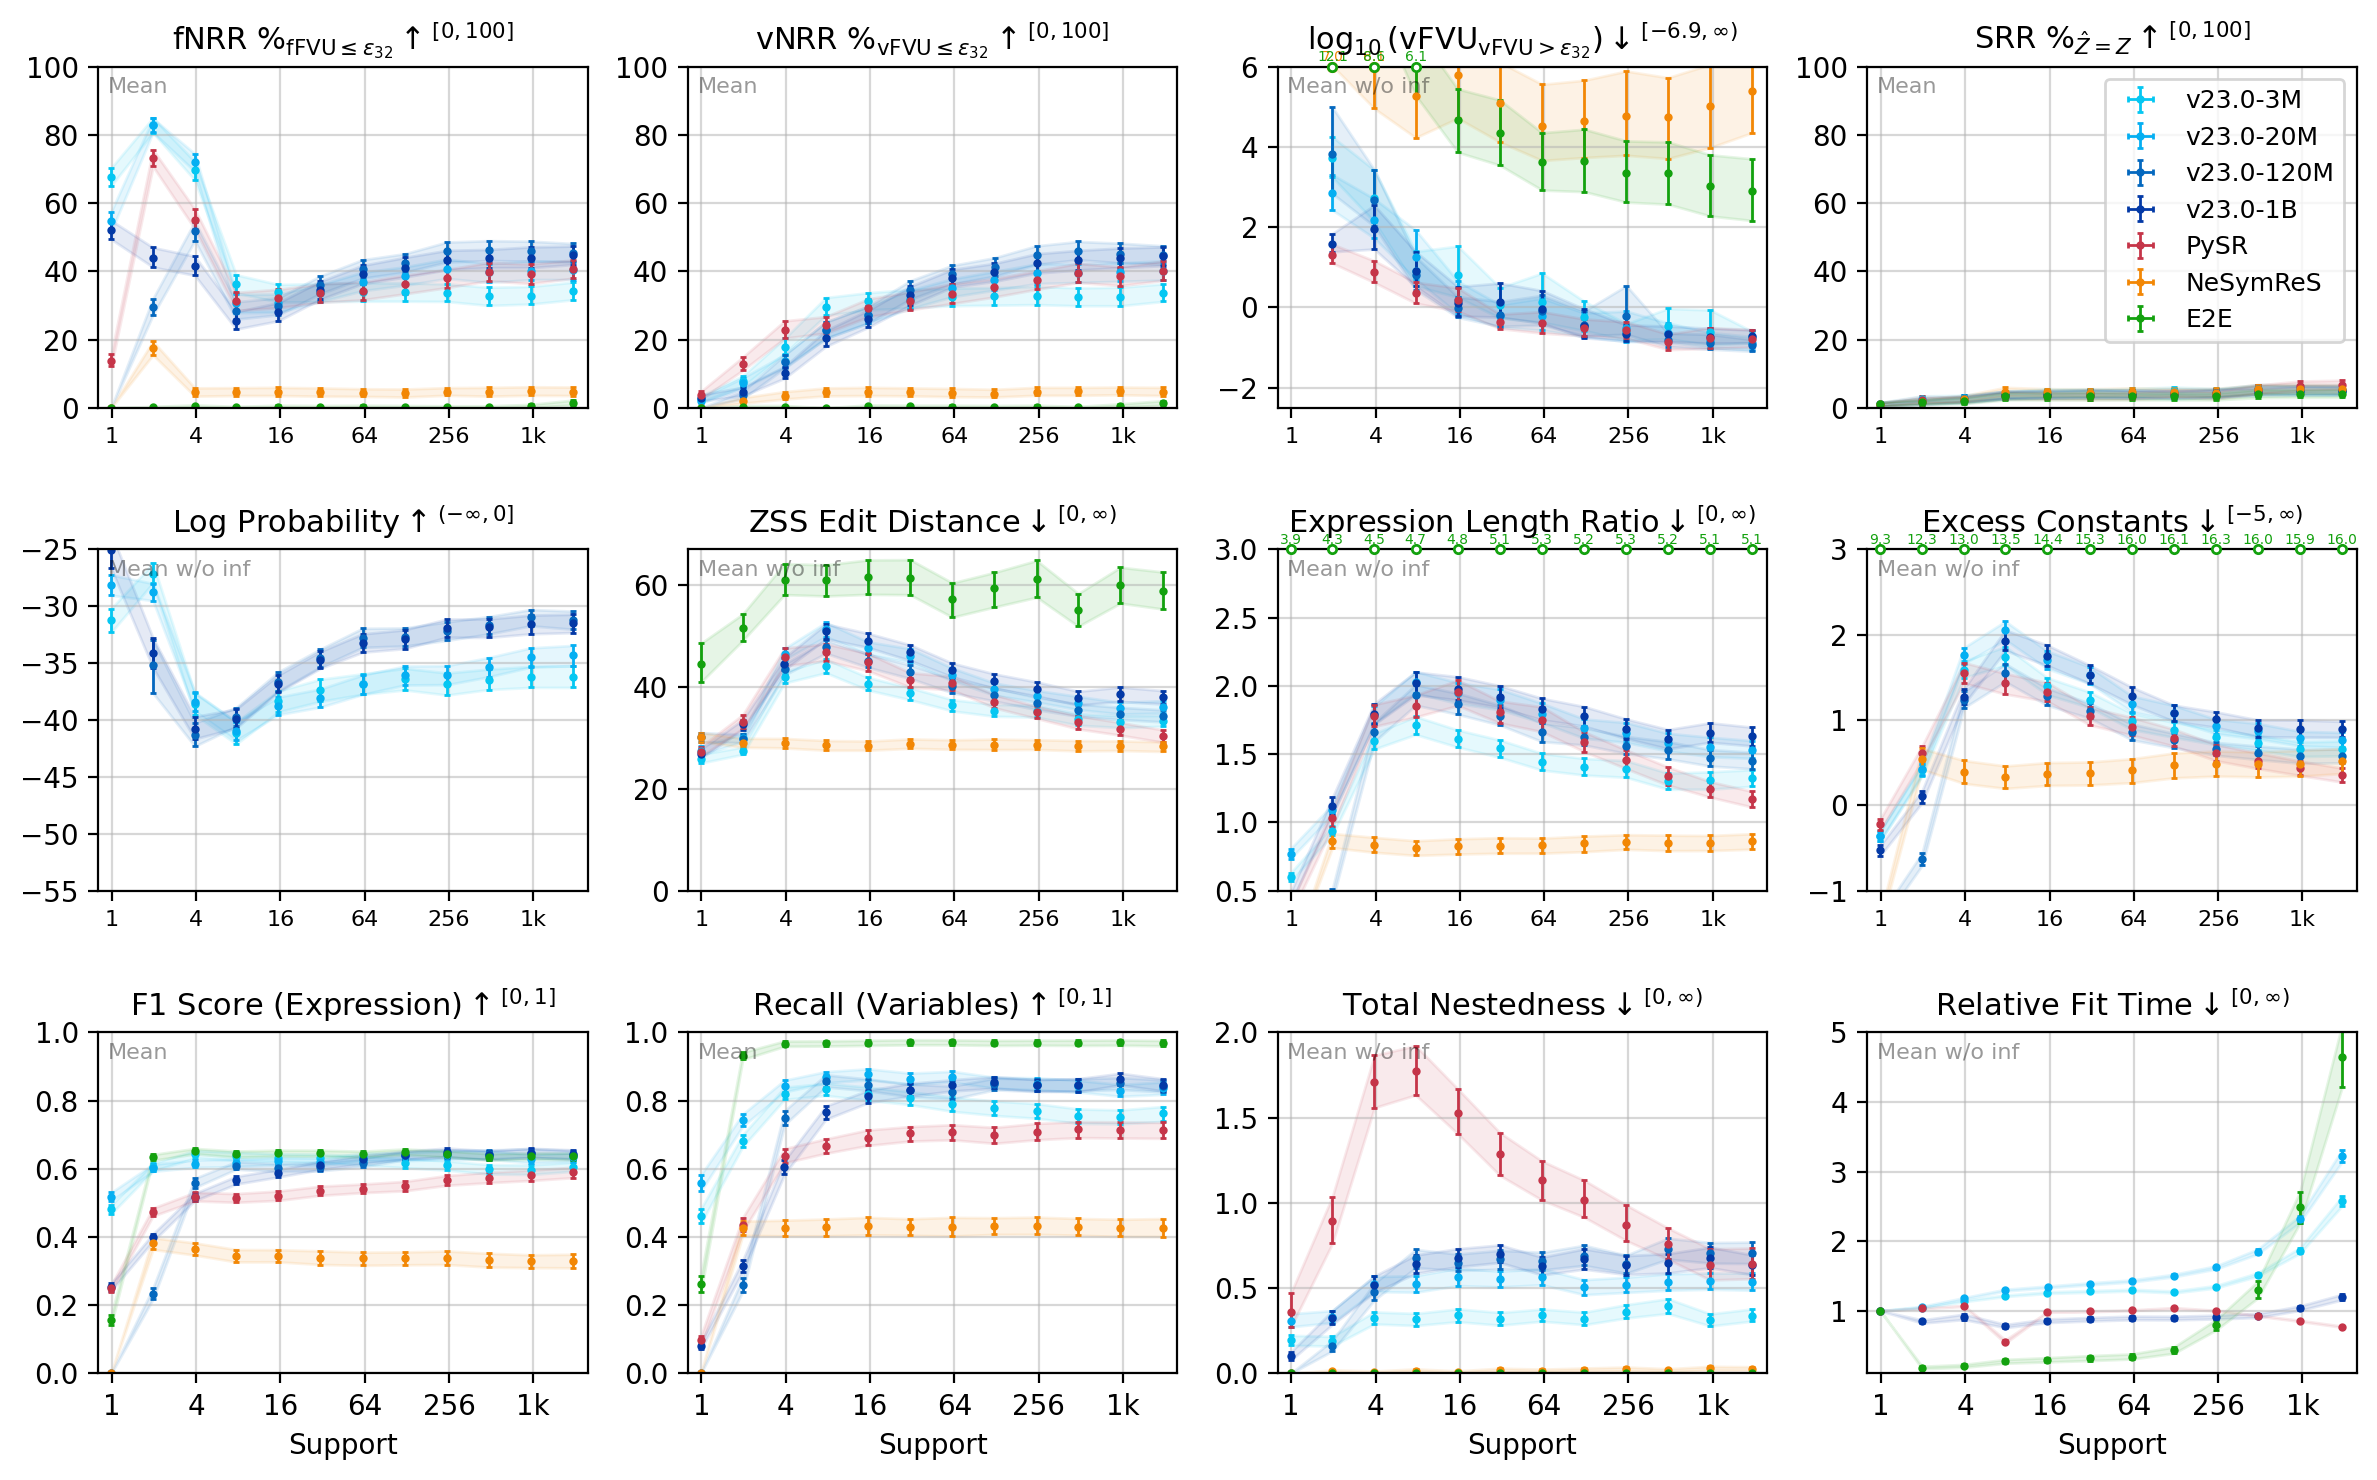

In [20]:
first_model = list(results.keys())[0]
gt_constants = results[first_model]['results']['fastsrb'][1]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('n_support', 'Support', naninfmean), (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{fFVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('n_support', 'Support', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{vFVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('n_support', 'Support', naninfmean), (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{vFVU}}_{{\\mathrm{{vFVU}} > \epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        naninfmean,
        1,
        (-2.5, 6)
    )),
    (('n_support', 'Support', naninfmean), (
        'symbolic_recovery',
        f'SRR $\\%_{{\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('n_support', 'Support', naninfmean), (
        'predicted_log_prob',
        f'$\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-55, -25)
    )),
    (('n_support', 'Support', naninfmean), (
        'zss_edit_distance',
        f'$\mathrm{{ZSS\\ Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 67)
    )),
    (('n_support', 'Support', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3)
    )),
    (('n_support', 'Support', naninfmean), (
        'n_constants_delta',
        f'$\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=-max_gt_constants, upper=np.inf)}$',
        naninfmean,
        1,
        (-1, 3)
    )),
    (('n_support', 'Support', naninfmean), (
        'f1_score',
        f'$\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1)
    )),
    # (('fit_time', 'Test Time Compute', naninfmean), (
    #     'precision_unique_variables',
    #     f'$\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
    #     np.nanmean,
    #     1,
    #     (0, 1)
    # )),
    (('n_support', 'Support', naninfmean), (
        'recall_unique_variables',
        f'$\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1)
    )),
    (('n_support', 'Support', naninfmean), (
        'predicted_total_nestedness',
        f'$\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 2)
    )),
    # (('fit_time', 'Test Time Compute', naninfmean), (
    #     'prediction_success',
    #     f'$\mathrm{{Fit\\ Success}}\\ \\% {arrow_notation(objective=1, lower=0, upper=100)}$',
    #     naninfmean,
    #     100,
    #     (0, 100)
    # )),
    (('n_support', 'Support', naninfmean), (
        'fit_time_multiplier',
        f'$\mathrm{{Relative\\ Fit\\ Time}}{arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.1, 5)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    ('v23.0-1B', 'choices', '#0339A6', 'v23.0-1B'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    ('e2e', 'candidates_per_bag', "#13a10e", 'E2E'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

test_set = 'fastsrb'
# test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)

short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

for ax_id, (ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            x = results[model_name]['results'][test_set][n][x_metric]

            # 1. Compute X CI
            if len(x) == 0:
                x_ci = (np.nan, np.nan, np.nan)
            else:
                x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)

            # 2. Compute Y CI
            if y_metric == 'fit_time_multiplier':
                # ... (existing fit_time_multiplier logic) ...
                baseline_times = results[model_name]['results'][test_set][min(results[model_name]['scaling_values'])]['fit_time']
                this_times = results[model_name]['results'][test_set][n]['fit_time']

                if baseline_times.shape != this_times.shape:
                    print(f'Skipping {model_name} at {n} due to shape mismatch.')
                    continue

                combined_for_bootstrapping = np.array([baseline_times, this_times]).T
                y_ci = bootstrapped_metric_ci(combined_for_bootstrapping, lambda x: naninfmean(x[:, 1] / x[:, 0]), n=1e3, interval=0.95)

                print(f"Model {model_name} at n={n}: Fit time multiplier CI: {y_ci}")
            else:
                y = results[model_name]['results'][test_set][n][y_metric]

                # Filter -inf for log10 FVU
                if y_metric == 'only_approx_log10_fvu_val':
                    y = y[y != -np.inf]

                # CHECK: If y is empty after filtering, skip bootstrapping
                if len(y) == 0:
                    y_ci = (np.nan, np.nan, np.nan)
                else:
                    y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            # Ensure we don't append incomplete data
            if not np.isnan(x_ci[0]) and not np.isnan(y_ci[0]):
                x_median.append(x_ci[0])
                x_lower.append(x_ci[1])
                x_upper.append(x_ci[2])

                y_median.append(y_ci[0])
                y_lower.append(y_ci[1])
                y_upper.append(y_ci[2])
            
        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        # 1. Standard Plotting
        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_label, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        # 2. Out-of-bounds Indicators (Upper Limit)
        if ylim[1] is not None:
            upper_limit = ylim[1]
            # Identify data points where the median is above the axis limit
            oob_mask = y_median > upper_limit

            if np.any(oob_mask):
                ax.plot(
                    x_median[oob_mask], 
                    np.full(oob_mask.sum(), upper_limit), # Clamp y position to the upper limit
                    marker='o', 
                    linestyle='None', 
                    markerfacecolor='white', 
                    markeredgecolor=color, 
                    markeredgewidth=1.0,
                    markersize=3, 
                    clip_on=False, # Allow drawing on top of the axis spine
                    zorder=100     # Ensure it renders above the axis spine
                )

                print(f"Model {model_name} has {oob_mask.sum()} out-of-bounds points for metric {y_metric} (upper limit: {upper_limit})")
                # Print the corresponding x and values of all out-of-bounds points
                for x_val, y_val in zip(x_median[oob_mask], y_median[oob_mask]):
                    print(f"  OOB Point - x: {x_val:.2f}, y: {y_val:.2f}")
                
                # Annotate the values that are out-of-bounds
                for x_oob, y_oob in zip(x_median[oob_mask], y_median[oob_mask]):
                    ax.annotate(f"{y_oob:.1f}", xy=(x_oob, upper_limit), xytext=(0, 1), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=color, clip_on=False)

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=10
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log', base=2)
    ax.set_xticks([1, 4, 16, 64, 256, 1024])
    ax.set_xticklabels(['1', '4', '16', '64', '256', '1k'], fontsize=x_ticks_fontsize)
    ax.set_xlim(0.8, 2500)

    ax.grid(alpha=0.5)

axes.flatten()[3].legend(fontsize=9)

for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')
    
    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'support_sweep', create=True, filename=f'n_support_{test_set}.svg'), dpi=200)

In [21]:
# Find out why vNRR is 100% at 1 point
results['pysr']['results']['fastsrb'][1].keys()

dict_keys(['skeleton', 'skeleton_hash', 'expression', 'constants', 'variables', 'variable_names', 'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'n_support', 'labels_decoded', 'complexity', 'noise_level', 'parsimony', 'fit_time', 'predicted_expression', 'predicted_expression_prefix', 'predicted_skeleton_prefix', 'predicted_constants', 'predicted_score', 'predicted_log_prob', 'y_pred', 'y_pred_val', 'prediction_success', 'error', 'placeholder', 'placeholder_reason', 'input_ids', 'labels', 'benchmark_eq_id', 'benchmark_sample_index', 'benchmark_metadata', 'benchmark_n_points', 'benchmark_support_points', 'benchmark_method', 'ground_truth_infix', 'ground_truth_prefix', 'predicted_skeleton_prefix_raw', 'fvu_fit', 'log10_fvu_fit', 'numeric_recovery_fit', 'only_approx_fvu_fit', 'only_approx_log10_fvu_fit', 'fvu_val', 'log10_fvu_val', 'numeric_recovery_val', 'only_approx_fvu_val', 'only_approx_log10_fvu_val', 'skeleton_simplified', 'f1_score', 'skeleton_length', 'predicted_skeleton_pre

In [22]:
results['pysr']['results']['fastsrb'][1]['x'][0]

array([[3.5311170e+00, 5.2142977e-03, 1.5429601e-03, 3.7336069e-01]],
      dtype=float32)

In [23]:
results['pysr']['results']['fastsrb'][1]['x_val'][0]

array([[0.75466967, 0.00248162, 0.0893809 , 0.01803962]], dtype=float32)

In [24]:
results['pysr']['results']['fastsrb'][1]['x_val'][0]

array([[0.75466967, 0.00248162, 0.0893809 , 0.01803962]], dtype=float32)

In [25]:
results['pysr']['results']['fastsrb'][1]['y_val'][0]

array([0.0092792], dtype=float32)

In [26]:
results['pysr']['results']['fastsrb'][1]['y_pred_val'][0]

array([[7.609113e-05]])

In [27]:
results['pysr']['results']['fastsrb'][1]['log10_fvu_val'][0]

np.float64(inf)

In [28]:
def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
    
    print(y_pred)
    print(y_true)
        
    if not isinstance(y_pred, np.ndarray) and np.isnan(y_pred):
        return np.inf

    y_pred = y_pred.astype(np.float64).ravel()
    y_true = y_true.astype(np.float64).ravel()

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    print(ss_res)
    print(scale)

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    print(ss_res)
    print(ss_tot)

    return safe_divide(ss_res, ss_tot)

In [29]:
fvu(results['pysr']['results']['fastsrb'][1]['y_pred_val'][0][0], results['pysr']['results']['fastsrb'][1]['y_val'][0])

[0.0092792]
[7.609113e-05]
8.469714202020967e-05
11806.773831416755
11806.773831416755
0.0


inf

Model e2e has 12 out-of-bounds points for metric skeleton_length_ratio (upper limit: 3)
  OOB Point - x: 0.99, y: 3.90
  OOB Point - x: 1.97, y: 4.27
  OOB Point - x: 3.92, y: 4.52
  OOB Point - x: 7.73, y: 4.69
  OOB Point - x: 15.47, y: 4.83
  OOB Point - x: 30.93, y: 5.12
  OOB Point - x: 61.87, y: 5.26
  OOB Point - x: 123.84, y: 5.23
  OOB Point - x: 247.68, y: 5.30
  OOB Point - x: 490.67, y: 5.19
  OOB Point - x: 981.33, y: 5.14
  OOB Point - x: 1962.67, y: 5.15


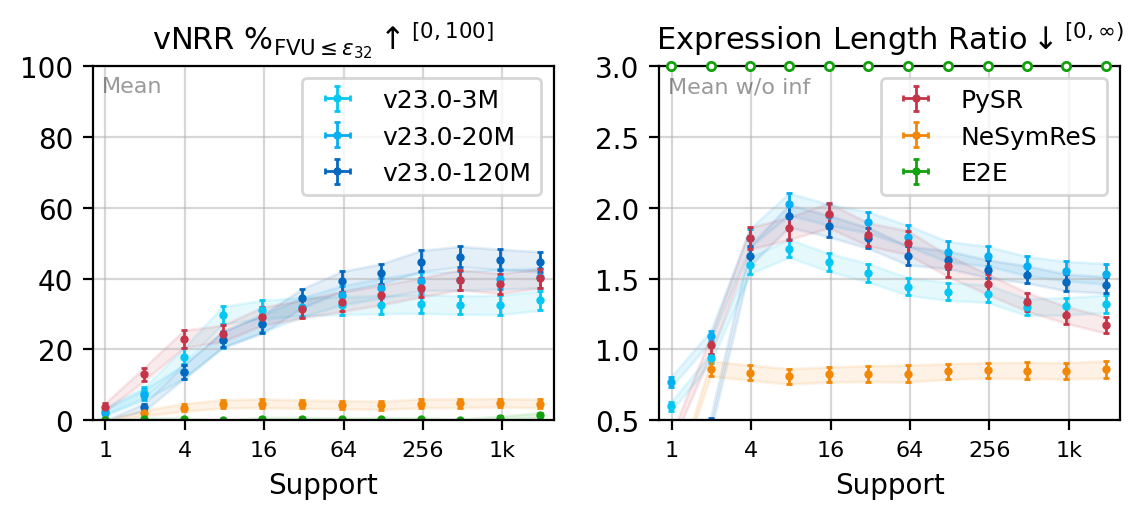

In [30]:
first_model = list(results.keys())[0]
gt_constants = results[first_model]['results']['fastsrb'][1]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('n_support', 'Support', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('n_support', 'Support', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    # ('v23.0-1B', 'choices', '#0339A6', 'v23.0-1B'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    ('e2e', 'candidates_per_bag', "#13a10e", 'E2E'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

if len(TEST_SETS) == 1:
    test_set = TEST_SETS[0]
else:
    test_set = 'fastsrb'
    # test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.9 * COLS, 2.7 * ROWS), dpi=200)


short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

models_per_legend_list = [
    ['v23.0-3M', 'v23.0-20M', 'v23.0-120M', 'v23.0-1B'],
    ['pysr', 'nesymres', 'e2e']
]

for ax_id, (models_per_legend, ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(models_per_legend_list, axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if model_name not in results or test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():

            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation (These are cases where the model found the exact solution and should be masked out)
            if y_metric == 'only_approx_log10_fvu_val':
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])
            
        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        if model_name not in models_per_legend:
            model_label_shown = None
        else:
            model_label_shown = model_label

        # 1. Standard Plotting
        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_label_shown, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        # 2. Out-of-bounds Indicators (Upper Limit)
        if ylim[1] is not None:
            upper_limit = ylim[1]
            # Identify data points where the median is above the axis limit
            oob_mask = y_median > upper_limit

            if np.any(oob_mask):
                ax.plot(
                    x_median[oob_mask], 
                    np.full(oob_mask.sum(), upper_limit), # Clamp y position to the upper limit
                    marker='o', 
                    linestyle='None', 
                    markerfacecolor='white', 
                    markeredgecolor=color, 
                    markeredgewidth=1.0,
                    markersize=3, 
                    clip_on=False, # Allow drawing on top of the axis spine
                    zorder=100     # Ensure it renders above the axis spine
                )

                print(f"Model {model_name} has {oob_mask.sum()} out-of-bounds points for metric {y_metric} (upper limit: {upper_limit})")
                # Print the corresponding x and values of all out-of-bounds points
                for x_val, y_val in zip(x_median[oob_mask], y_median[oob_mask]):
                    print(f"  OOB Point - x: {x_val:.2f}, y: {y_val:.2f}")
                
                # Annotate the values that are out-of-bounds
                # for x_oob, y_oob in zip(x_median[oob_mask], y_median[oob_mask]):
                #     ax.annotate(f"{y_oob:.1f}", xy=(x_oob, upper_limit), xytext=(0, 1), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=color, clip_on=False)

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=8
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log', base=2)
    ax.set_xticks([1, 4, 16, 64, 256, 1024])
    ax.set_xticklabels(['1', '4', '16', '64', '256', '1k'], fontsize=x_ticks_fontsize)
    ax.set_xlim(0.8, 2500)

    ax.grid(alpha=0.5)

axes.flatten()[0].legend(fontsize=9, loc='upper right')
axes.flatten()[1].legend(fontsize=9, loc='upper right')


for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')
    
    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=1.5, h_pad=2)


plt.savefig(get_path('results', 'support_sweep', create=True, filename=f'small_n_support_{test_set}.svg'), dpi=200)